# SXCT data preprocessing - Image filtering pipeline
Slicewise filtering of 3D SXCT dataset for 8-bit format data. This step facilitates further segmentation steps.
The dataset was collected at the [BEATS beamline](https://beats-sesame.eu/) of [SESAME](https://www.sesame.org.jo/).

- By [Philipp Hans](https://github.com/gianthk/BEATS-CH2024/commits?author=phlpphns), SESAME, 2024
- Code license: MIT
- Narrative license: CC-BY-NC-SA
- Created on:  01.05.2024 <br />
- Last update: 22.07.2024 <br />


| Sample   | Roman glass                             |
|:-----------------------|:-------------------------------|
| Scan name              | glass_room-M_stitch-20240222T153555   |
| Energy                 | 20 keV                         |
| Detector               | Det 2 (Hasselblad system)      |
| Camera                 | ORYX FLIR 7.1 MP GigE          |
| Voxel size             | 4.5 um                         |
| SDD                    | 250 mm                         |
| Field of view extension | 360-degree x 3 stitch scans |

### Pre processing
The following steps were applied to the dataset before running this pipeline:
1. CT reconstruction with Pagainin phase-retrieval and extended field-of-view sinogram stitching. See notebook `BEATS_recon_Roman_glass.ipynb`
2. Stitching of vertically extended scan. The procedure and Python code for vertical stitching of reconstructed datasets are described [here](https://github.com/gianthk/recon_utils/tree/master/stitch_scan).
3. Image cropping and 8-bit conversion. Due to the size of the scan, the dataset had to be converted to 8-bit format for further image processing. These steps were performed in [FIJI ImageJ](https://imagej.net/software/fiji/).


Type `Ctrl` + `Enter` on a single cell to run it.

## Import Python modules
- The following list of dependencies is used for CT recinstruction with TomoPy at SESAME BEATS. 
- Local paths to your ImageJ installation, data, and [recon_utils](https://github.com/gianthk/recon_utils) repository should be updated. 

In [1]:
import os
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import cv2

## Custom function definition

In [2]:
def load_image_stack(image_paths):
    # Load all images in the provided list of image paths and return as a list
    images = [
        cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) for image_path in image_paths
    ]
    return images


def compute_global_otsu(images):
    # Concatenate all images into a single array for global threshold computation
    concatenated = np.concatenate([image.flatten() for image in images])
    global_otsu_threshold, _ = cv2.threshold(
        concatenated, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    return global_otsu_threshold


def apply_bilateral_filter(image, d=9, sigma_color=75, sigma_space=75):
    # Apply Bilateral Filter
    filtered_image = cv2.bilateralFilter(image, d, sigma_color, sigma_space)
    return filtered_image


def apply_morphological_transformations(image, kernel_size=5):
    # Apply Morphological Transformations (Erosion followed by Dilation)
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    eroded_image = cv2.erode(image, kernel, iterations=1)
    opened_image = cv2.dilate(eroded_image, kernel, iterations=1)
    return opened_image


def apply_lower_otsu(image, global_otsu_threshold, lower_ratio=0.75):
    # Calculate the lower threshold value based on the ratio
    lower_threshold = int(lower_ratio * global_otsu_threshold)

    # Apply the lower threshold to create a binary mask
    _, lower_otsu_mask = cv2.threshold(image, lower_threshold, 255, cv2.THRESH_BINARY)

    # Invert the mask
    inverted_mask = cv2.bitwise_not(lower_otsu_mask)

    return inverted_mask, global_otsu_threshold, lower_threshold


def close_mask(mask, kernel_size=20):
    # Define a kernel for morphological operations
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Apply morphological closing (dilation followed by erosion)
    closed_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    return closed_mask


def visualize_results(
    original_image,
    processed_image,
    closed_mask,
    masked_image,
    otsu_threshold,
    lower_threshold,
):
    plt.figure(figsize=(14, 10))

    plt.subplot(1, 4, 1)
    plt.imshow(original_image, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(processed_image, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.imshow(closed_mask, cmap='gray')
    plt.title(f'Inverted Mask\nOtsu: {otsu_threshold}, Lower: {lower_threshold}')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(masked_image)
    plt.title("Masked Image")
    plt.axis("off")

## Local path settings
Here we can set path settings to access the data depending on the operating system we are on 

In [3]:
DICT_PREFIXES = {}
DICT_PREFIXES["PREFIX_WINDOWS_NETWORK"] = r"\\10.1.14.100\\beats-ih"
DICT_PREFIXES["PREFIX_RUM"] = "/PETRA/SED/BEATS/IH/"
DICT_PREFIXES["TRYING_OUT"] = "../example_images/"  # we are in the notebook directory and must go to the directory with
                                                    # example images one directory up

## Find and sort image files

In [4]:
PREFIX = DICT_PREFIXES.get("PREFIX_WINDOWS_NETWORK")
PREFIX = DICT_PREFIXES.get("PREFIX_RUM")
PREFIX = DICT_PREFIXES.get('TRYING_OUT')

In [5]:
slice_dir = new_directory_output = os.path.join(
    PREFIX, "slices_roman_glass_8bit_cropped"
)
out_dir = new_directory_output = os.path.join(
    PREFIX,
    "slices_roman_glass_processed",
)

os.makedirs(out_dir, exist_ok=True)

slices = sorted(os.listdir(slice_dir))

all_files = [os.path.join(slice_dir, slice) for slice in slices]
for file_name in all_files:
    print(file_name)
print(len(all_files))

image_paths = all_files[:]
images_for_otsu_thresholding = load_image_stack(image_paths)


../example_images/slices_roman_glass_8bit_cropped/slice_0032.tif
../example_images/slices_roman_glass_8bit_cropped/slice_0052.tif
../example_images/slices_roman_glass_8bit_cropped/slice_0083.tif
../example_images/slices_roman_glass_8bit_cropped/slice_0107.tif
../example_images/slices_roman_glass_8bit_cropped/slice_0140.tif
../example_images/slices_roman_glass_8bit_cropped/slice_0173.tif
../example_images/slices_roman_glass_8bit_cropped/slice_0212.tif
../example_images/slices_roman_glass_8bit_cropped/slice_0248.tif
../example_images/slices_roman_glass_8bit_cropped/slice_0275.tif
../example_images/slices_roman_glass_8bit_cropped/slice_0296.tif
../example_images/slices_roman_glass_8bit_cropped/slice_0364.tif
../example_images/slices_roman_glass_8bit_cropped/slice_0400.tif
../example_images/slices_roman_glass_8bit_cropped/slice_0439.tif
../example_images/slices_roman_glass_8bit_cropped/slice_0472.tif
../example_images/slices_roman_glass_8bit_cropped/slice_0505.tif
../example_images/slices_

## Defining a global threshold
Find a global threshold for the entire 3D volume: load a significant portion of the image stack and compute global Otsu threshold

In [6]:
global_otsu_threshold = compute_global_otsu(images_for_otsu_thresholding)

print("global_otsu_threshold:    ", global_otsu_threshold)


global_otsu_threshold:     116.0


## Slice-wise image filtering
For a user defined selection, we can now loop over each image, process and save it.
The filtered images are easier to process in terms of thresholding but still require 3D image processing steps that we perform in ORS Dragonfly.

**The filtering procedure comprises:**
1. Apply a [bilateral smoothing filter from OpenCV](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga9d7064d478c95d60003cf839430737ed). The filter is effective at reducing image noise while maintaining the image edges sharp. 
2. 2D image opening (image erosion followed by dilation) applied to the greyscale images.
3. Segmentation of the object of interest with global lower threshold. The threshold level is calculated globally for the whole 3D stack with Otsu's method (see cell above).
4. 2D morphological closing (dilation followed by erosion) applied to the binary sample mask.


Notes:
- The routine takes care to process only images that have not already been processed
- If you delete or forget one image you can selectively process that
- The parameters used in the functions were selected based on visual inspection of a range of slices and could vary for another dataset
- The plot below shows original, filtered, thresholded, and masked images for a set of slices at various heights of the 3D stack

name new file:   ../example_images/slices_roman_glass_processed/slice_0032.tif


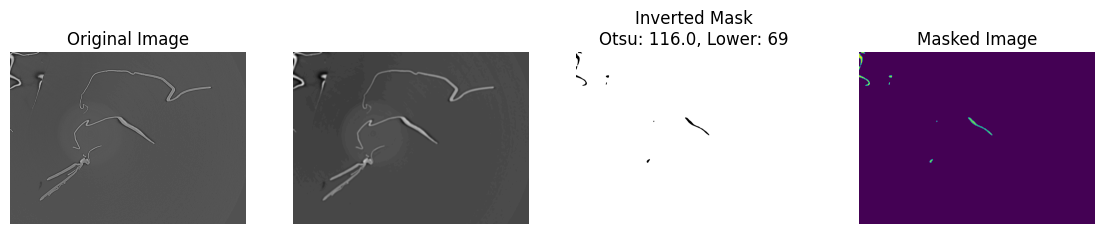

name new file:   ../example_images/slices_roman_glass_processed/slice_0173.tif


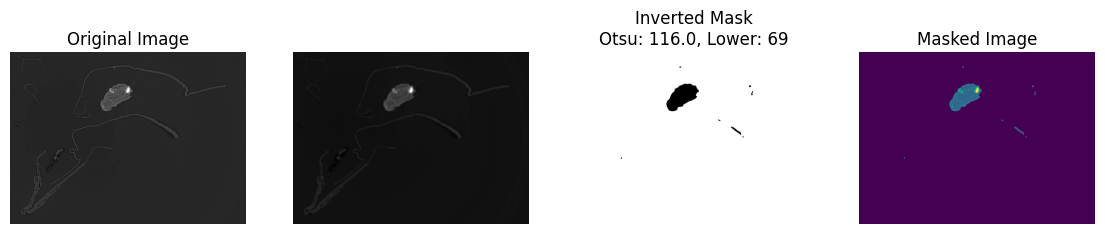

name new file:   ../example_images/slices_roman_glass_processed/slice_0364.tif


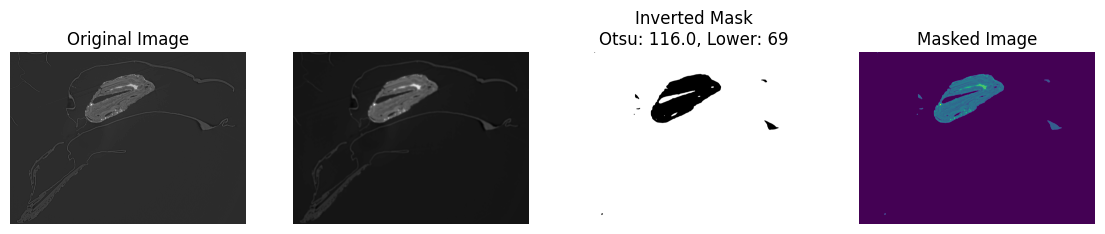

name new file:   ../example_images/slices_roman_glass_processed/slice_0535.tif


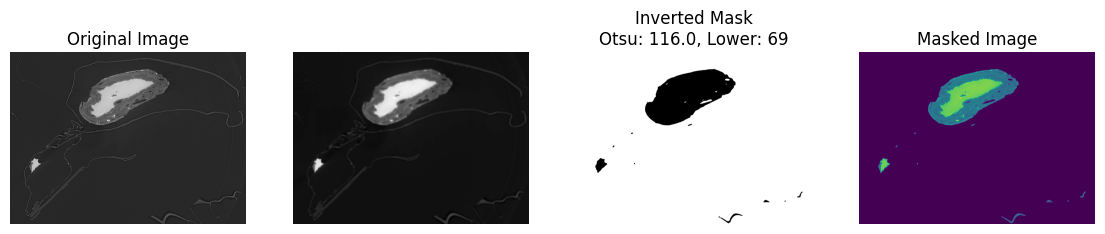

name new file:   ../example_images/slices_roman_glass_processed/slice_0673.tif


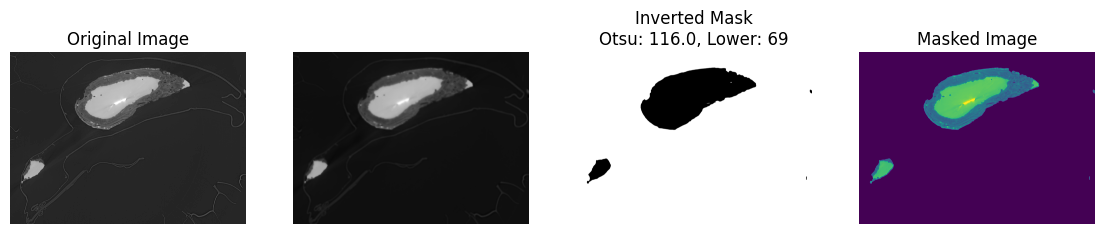

name new file:   ../example_images/slices_roman_glass_processed/slice_1162.tif


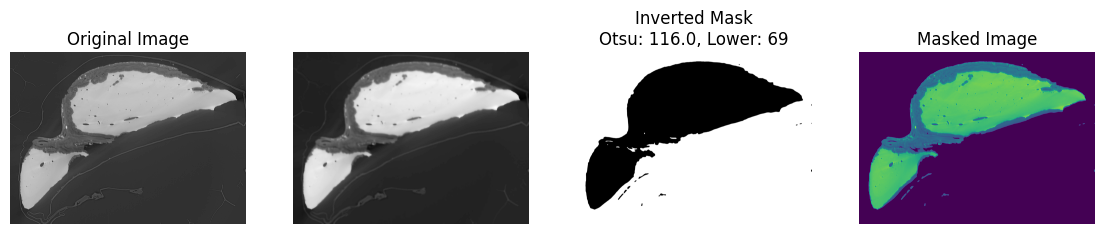

name new file:   ../example_images/slices_roman_glass_processed/slice_1369.tif


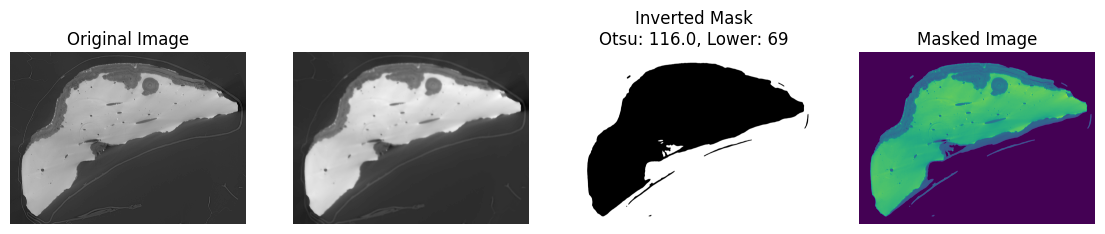

name new file:   ../example_images/slices_roman_glass_processed/slice_1612.tif


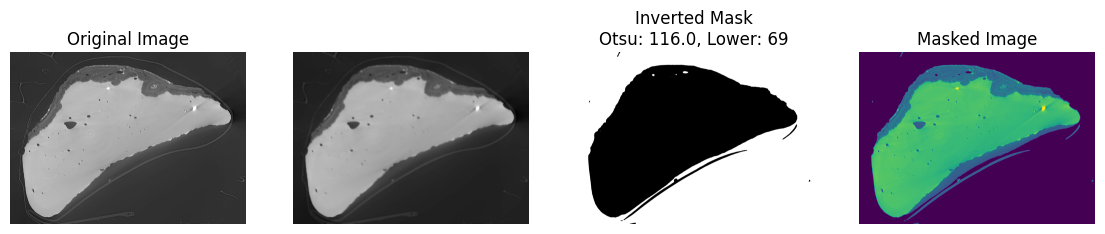

name new file:   ../example_images/slices_roman_glass_processed/slice_2071.tif


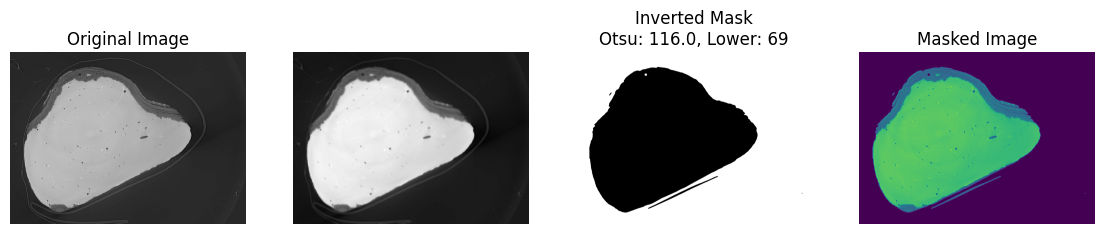

name new file:   ../example_images/slices_roman_glass_processed/slice_2413.tif


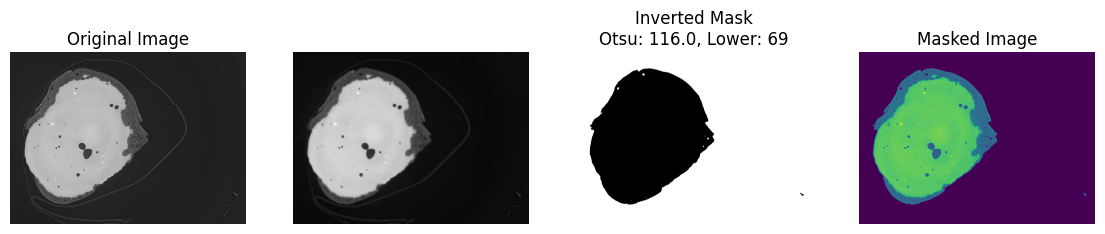

name new file:   ../example_images/slices_roman_glass_processed/slice_3195.tif


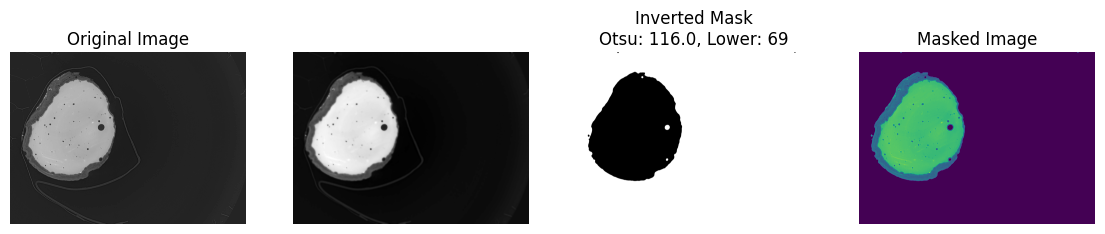

name new file:   ../example_images/slices_roman_glass_processed/slice_4911.tif


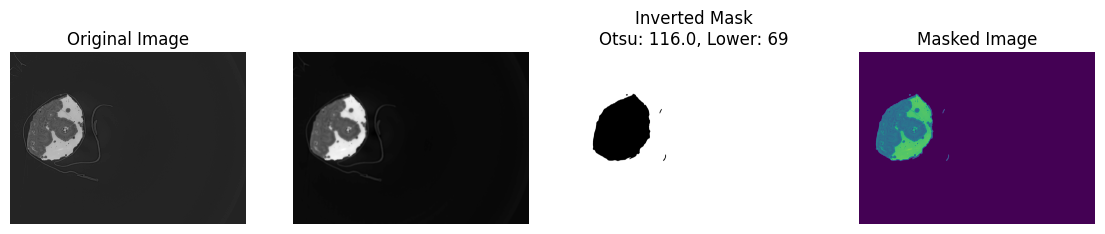

In [7]:
for image_path in all_files[::5]:
    
    tiff_name = os.path.basename(image_path)
    
    name_tiff_file_new = f'{os.path.join(out_dir, f"{tiff_name}")}'
    
    print(f"name new file:   {name_tiff_file_new}")
    
    if os.path.isfile(name_tiff_file_new):
        print("f{name_tiff_file_new}\nalready exists\n\n")
        continue
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    masked_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    bilateral_filtered_image = apply_bilateral_filter(
        image,
        d=70,
        sigma_color=100,
        sigma_space=10,
    )
    
    morphologically_transformed_image = apply_morphological_transformations(
        bilateral_filtered_image,
        kernel_size=5,
    )

    # Apply lower Otsu thresholding and invert the mask using global Otsu threshold
    inverted_mask, otsu_threshold, lower_threshold = apply_lower_otsu(
        morphologically_transformed_image, global_otsu_threshold, lower_ratio=0.60
    )

    # Close the inverted mask to fill gaps
    closed_mask = close_mask(inverted_mask, kernel_size=10)
    closed_mask[closed_mask != 0] = True
    closed_mask[closed_mask == 0] = False

    # set the image at all points where the mask lies to zero (and thereby
    # remove disturbing parts such as the parafilm the sample was wrapped in)
    masked_image[closed_mask.astype("bool")] = 0
    
    # Visualize the results
    visualize_results(
        image, morphologically_transformed_image, closed_mask, masked_image, otsu_threshold, lower_threshold
    )
    plt.show()

    # save improved image, uncomment the next line to save the processed image to the dedicated "out_dir"

    #tifffile.imwrite(name_tiff_file_new, image)
    #print("file_written\n\n\n")